# Calibration of a Residual Demand Model

In [1]:
import sys
sys.path.append('../..')

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rivapy.models import OrnsteinUhlenbeck, residual_demand_model as rdm
from rivapy.sample_data import residual_demand_models
from rivapy.tools.datetime_grid import DateTimeGrid, InterpolatedFunction, PeriodicFunction


%load_ext autoreload
%autoreload 2
%matplotlib inline

../..\rivapy\__init__.py:8: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


## Read Data

In [2]:
capacities = pd.read_csv('../test_data/capacities.csv', parse_dates=['year'])
capacities['year'] = capacities['year'].dt.tz_convert('UTC')
capacities.set_index('year', inplace=True)
power_prices = pd.read_csv('../test_data/hist_prices.csv', parse_dates=['Date'])
#power_prices['Date'] = power_prices['Date'].dt.tz_convert('CET')
power_prices.set_index('Date', inplace=True)
wind_onshore = pd.read_csv('../test_data/onshore.csv', parse_dates=['Datum']).rename(columns={'0':'production'}, inplace = False)
wind_onshore=wind_onshore[wind_onshore['Datum']>capacities.index[0]]
#wind_onshore['Datum'] = wind_onshore['Datum'].dt.tz_convert('CET')
wind_onshore.set_index('Datum', inplace=True)
wind_offshore = pd.read_csv('../test_data/offshore.csv', parse_dates=['Datum']).rename(columns={'0':'production'}, inplace = False)
wind_offshore=wind_offshore[wind_offshore['Datum']>capacities.index[0]]
#wind_offshore['Datum'] = wind_offshore['Datum'].dt.tz_convert('CET')
wind_offshore.set_index('Datum', inplace=True)
solar = pd.read_csv('../test_data/solar.csv', parse_dates=['Datum']).rename(columns={'0':'production'}, inplace = False)
solar=solar[solar['Datum']>capacities.index[0]]
solar.set_index('Datum', inplace=True)

# Wind Onshore

In [93]:
capacities_interp = InterpolatedFunction(capacities.index, capacities['onshore'])

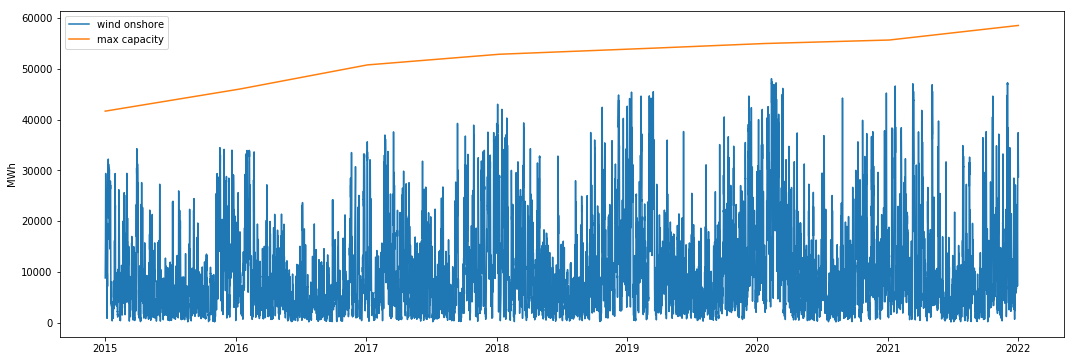

In [94]:
plt.figure(figsize=(18,6))
plt.plot(wind_onshore, label='wind onshore')
plt.plot(wind_onshore.index.values, capacities_interp.compute(wind_onshore.index), label='max capacity');
plt.ylabel('MWh')
plt.legend();

## Transform to efficiency (production relative to capacity)

In [95]:
wind_onshore['efficiency'] = wind_onshore['production']/capacities_interp.compute(wind_onshore.index)

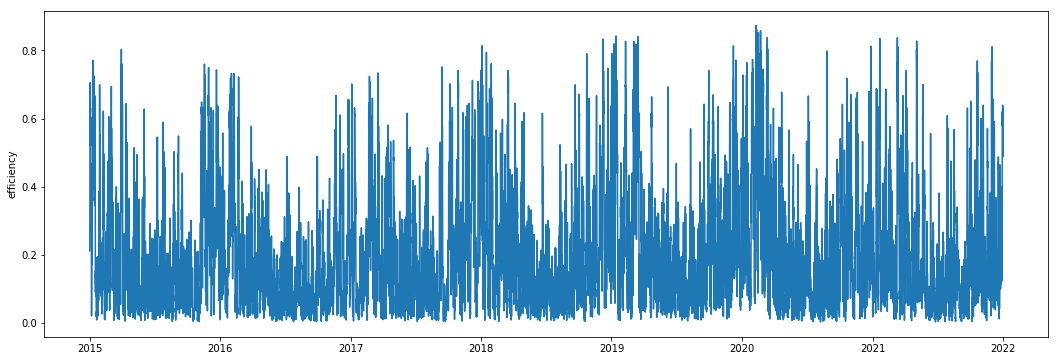

In [97]:
plt.figure(figsize=(18,6))
plt.ylabel('efficiency')
plt.plot(wind_onshore['efficiency'], label='wind onshore efficiency');

C:\Users\Anwender\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Anwender\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


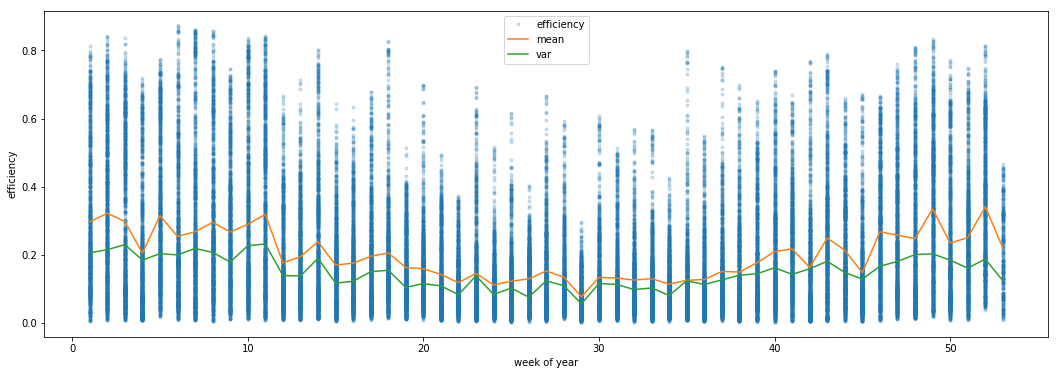

In [141]:
plt.figure(figsize=(18,6))
plt.plot(wind_onshore.index.isocalendar().week, wind_onshore.efficiency.values, '.', alpha=0.2, label='efficiency');
tmp = wind_onshore[['efficiency']].copy()
tmp['day_of_year'] = wind_onshore.index.isocalendar().week
plt.plot(tmp.groupby('day_of_year').mean(), label='mean')
plt.plot(np.sqrt(tmp.groupby('day_of_year').var()), label='stddev')
plt.ylabel('efficiency')
plt.xlabel('week of year')
plt.legend();

C:\Users\Anwender\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Anwender\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


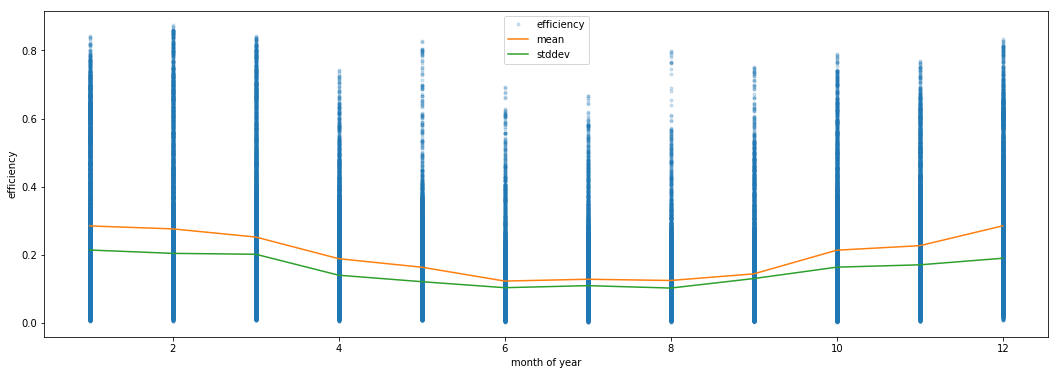

In [145]:
plt.figure(figsize=(18,6))
plt.plot(wind_onshore.index.month, wind_onshore.efficiency.values, '.', alpha=0.2, label='efficiency');
tmp = wind_onshore[['efficiency']].copy()
tmp['day_of_year'] = wind_onshore.index.month
plt.plot(tmp.groupby('day_of_year').mean(), label='mean')
plt.plot(np.sqrt(tmp.groupby('day_of_year').var()), label='stddev')
plt.ylabel('efficiency')
plt.xlabel('month of year')
plt.legend();

## Transform with logit

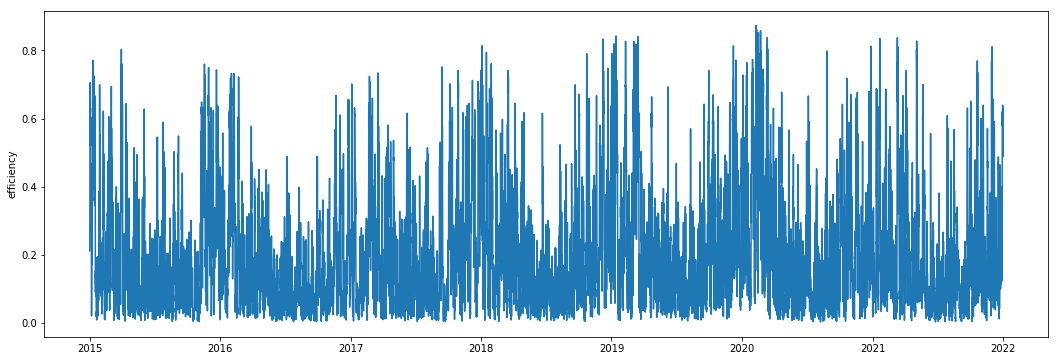

In [110]:
wind_onshore['logit_efficiency'] = rdm._logit(wind_onshore['efficiency'])
plt.figure(figsize=(18,6))
plt.ylabel('efficiency')
plt.plot(wind_onshore['efficiency'], label='wind onshore efficiency');

## Estimate Seasonality

In [8]:
class CosinusSeasonality:
    def __init__(self, x: np.ndarray = np.array([0,1,0,1,0])):
        self.x = x
        
    def __call__(self, x):
        return self.x[0]*np.cos(2*np.pi*x+self.x[1]) + self.x[2]*np.cos(4*np.pi*x+self.x[3]) + self.x[4]

In [111]:
f = CosinusSeasonality(x=np.array([1.0, 1, 0.9, 1.1, 0.5, -1.0]))
pf_target = PeriodicFunction(f, frequency='Y', granularity='H', ignore_leap_day=True)

In [112]:
pf_target.calibrate(wind_onshore.index, wind_onshore['logit_efficiency'].values)

C:\Users\Anwender\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


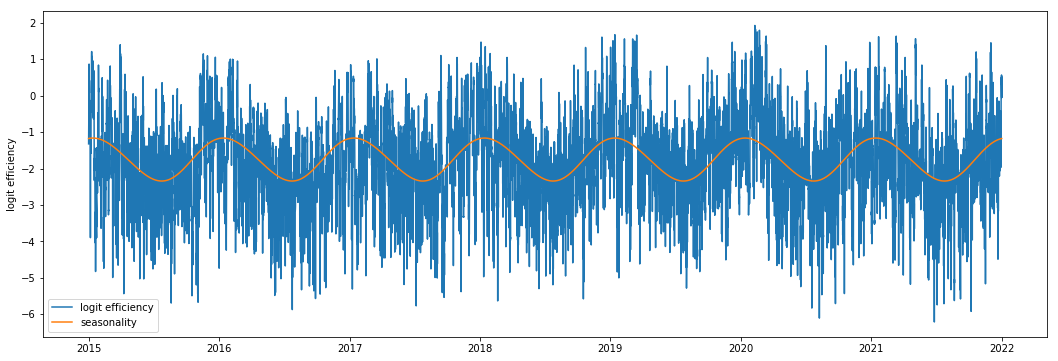

In [138]:
plt.figure(figsize=(18,6))
plt.ylabel('logit efficiency')
plt.plot(wind_onshore.index.values, wind_onshore['logit_efficiency'].values, label='logit efficiency')
plt.plot(wind_onshore.index.values, pf_target.compute(DateTimeGrid(wind_onshore.index)), label='seasonality')
plt.legend();

In [118]:
wind_onshore['des_logit_efficiency'] = wind_onshore['logit_efficiency']-pf_target.compute(DateTimeGrid(wind_onshore.index))

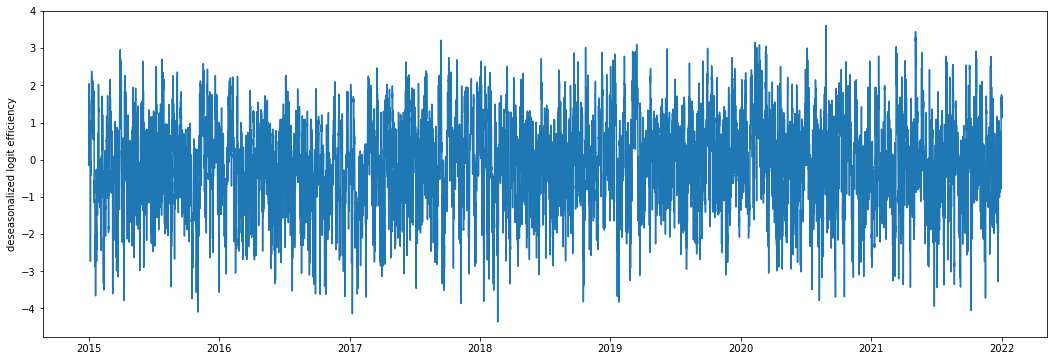

In [164]:
plt.figure(figsize=(18,6))
plt.ylabel('deseasonalized logit efficiency')
plt.plot(wind_onshore.index.values, wind_onshore['des_logit_efficiency'].values, label='wind onshore efficiency');

## Estimate OU

In [168]:
ou_model = OrnsteinUhlenbeck(speed_of_mean_reversion = 5.0, volatility=0.1)
ou_model.calibrate(wind_onshore['des_logit_efficiency'].values,dt=1.0/(24.0*365.0), method = 'maximum_likelihood')#'minimum_least_square')

## Setup Model

In [191]:
onshore_model = rdm.WindPowerModel(ou_model, pf_target)

In [205]:
n_sims = 100
np.random.seed(42)
tg = DateTimeGrid(start=dt.datetime(2022,1,1), end=dt.datetime(2023,1,1), freq='1H')
rnd = np.random.normal(size=(tg.shape[0], n_sims))
onshore_simulated = onshore_model.simulate(tg, start_value=0.5, rnd=rnd)

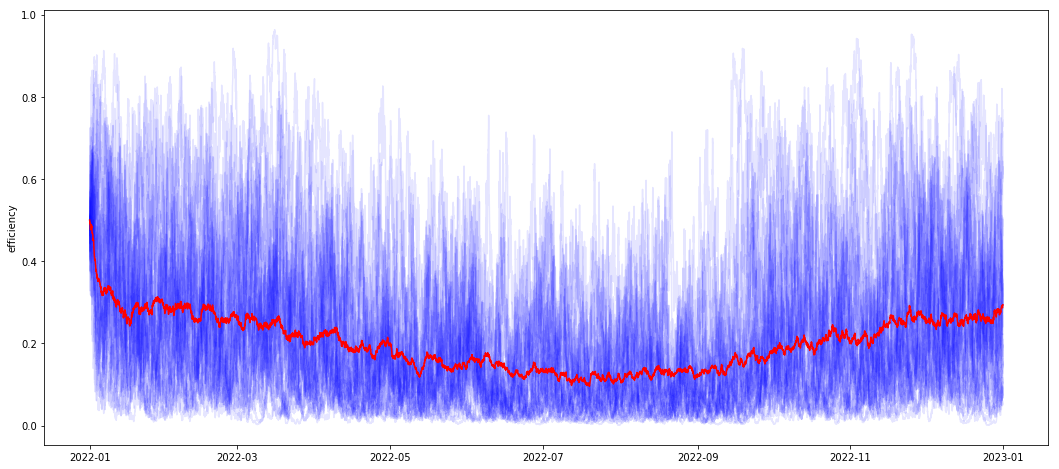

In [211]:
plt.figure(figsize=(18,8))
for i in range(30):
    plt.plot(tg.dates, onshore_simulated[:,i],'-b', alpha=0.1)
plt.plot(tg.dates, onshore_simulated.mean(axis=1), '-r', label='mean')
plt.ylabel('efficiency');

# Wind Offshore

We will now use the calibration method of the WindModel. Here, we just need to specify a model for the deviation process (in our case the OU model) and the periodic function.

In [244]:
capacity = capacities[['offshore']].rename(columns={'offshore': 'capacity'})
offshore_model = rdm.WindPowerModel.calibrate(OrnsteinUhlenbeck(speed_of_mean_reversion = 5.0, volatility=0.1),
                             capacity,
                             data=wind_offshore,
                             seasonality_function=CosinusSeasonality(x=np.array([1.0, 1, 0.9, 1.1, 0.5, -1.0])),
                             min_efficiency=0.001,
                             max_efficiency=0.99,
                             method = 'maximum_likelihood')

../..\rivapy\models\residual_demand_model.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['efficiency'] = data['production']/capacities_interp.compute(data.index)
C:\Users\Anwender\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# Solar

In [3]:
capacities_interp = InterpolatedFunction(capacities.index, capacities['solar'])
solar['efficiency'] = solar['production']/capacities_interp.compute(solar.index)
solar['capacity'] = capacities_interp.compute(solar.index)

## Estimate daily seasonality

In [22]:
solar['date'] = solar.index.normalize()
solar['hour'] = solar.index.hour
solar['month'] = solar.index.month
solar['day'] = solar.index.dayofyear

In [5]:
solar_day = solar.groupby(by='date').max()
solar_day['logit_efficiency'] = rdm._logit(solar_day['efficiency'])

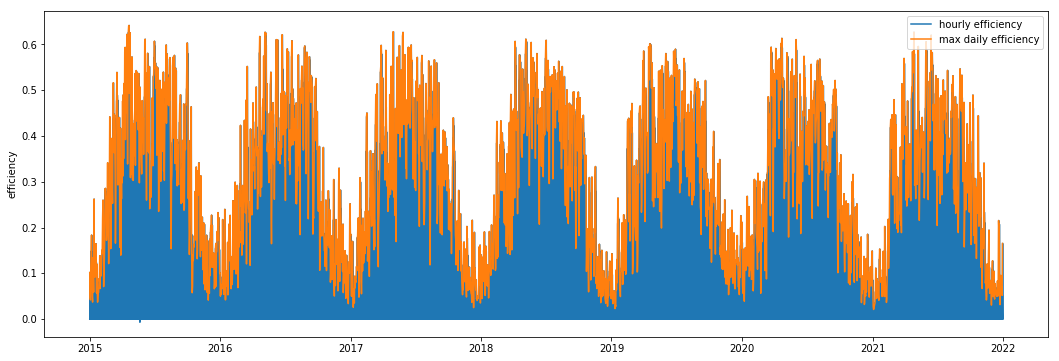

In [6]:
plt.figure(figsize=(18,6))
plt.plot(solar['efficiency'], label='hourly efficiency')
plt.plot(solar_day['efficiency'], label='max daily efficiency')
plt.legend()
plt.ylabel('efficiency');

In [10]:
f_solar = CosinusSeasonality(x=np.array([1.0, 1, 0.9, 1.1, 0.5, -1.0]))
pf_target_solar = PeriodicFunction(f_solar, frequency='Y', granularity='D', ignore_leap_day=True)

In [11]:
pf_target_solar.calibrate(solar_day.index, solar_day['logit_efficiency'].values)

C:\Users\Anwender\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


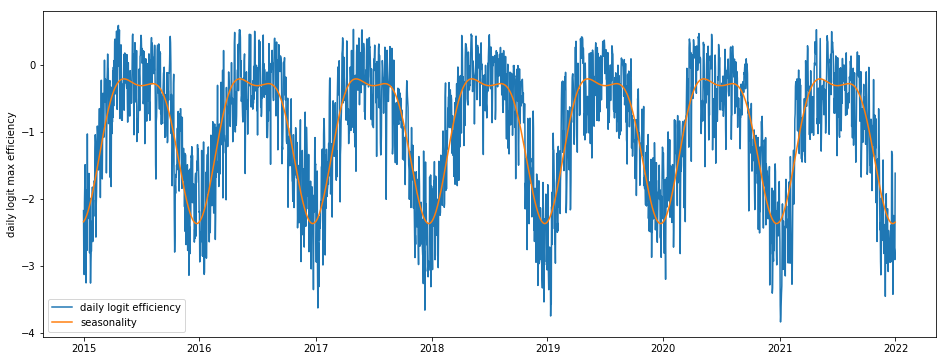

In [12]:
plt.figure(figsize=(16,6))
plt.plot(solar_day.index.values, solar_day['logit_efficiency'].values, label='daily logit efficiency')
plt.plot(solar_day.index.values, pf_target_solar.compute(DateTimeGrid(solar_day.index), solar_day['logit_efficiency']), label='seasonality')
plt.ylabel('daily logit max efficiency')
plt.legend();

## Estimate OU

In [14]:
solar_day['des_logit_efficiency'] = solar_day['logit_efficiency']-pf_target_solar.compute(DateTimeGrid(solar_day.index))
ou_model_solar = OrnsteinUhlenbeck(speed_of_mean_reversion = 5.0, volatility=0.1)
ou_model_solar.calibrate(solar_day['des_logit_efficiency'].values,dt=1.0/(365.0), method = 'maximum_likelihood')#'minimum_least_square')

## Estimate hourly profile

In [15]:
solar=solar.join(solar_day[['production']].rename(columns={'production': 'max_production'}), on='date')

In [45]:
solar['rel_production'] = solar['production']/solar['max_production']
monthly_solar_profile = np.zeros(shape=(12,24))
monthly_solar_profile_median = np.zeros(shape=(12,24))
for i in range(1,13):
    for j in range(24):
        sel = solar[(solar.index.month==i)&(solar.index.hour==j)]['rel_production']
        monthly_solar_profile[i-1,j] = sel.mean()
        monthly_solar_profile_median[i-1,j] = sel.median()
        #print(sel.mean())

In [44]:
solar_profile = rdm.MonthlySolarProfile(monthly_solar_profile)

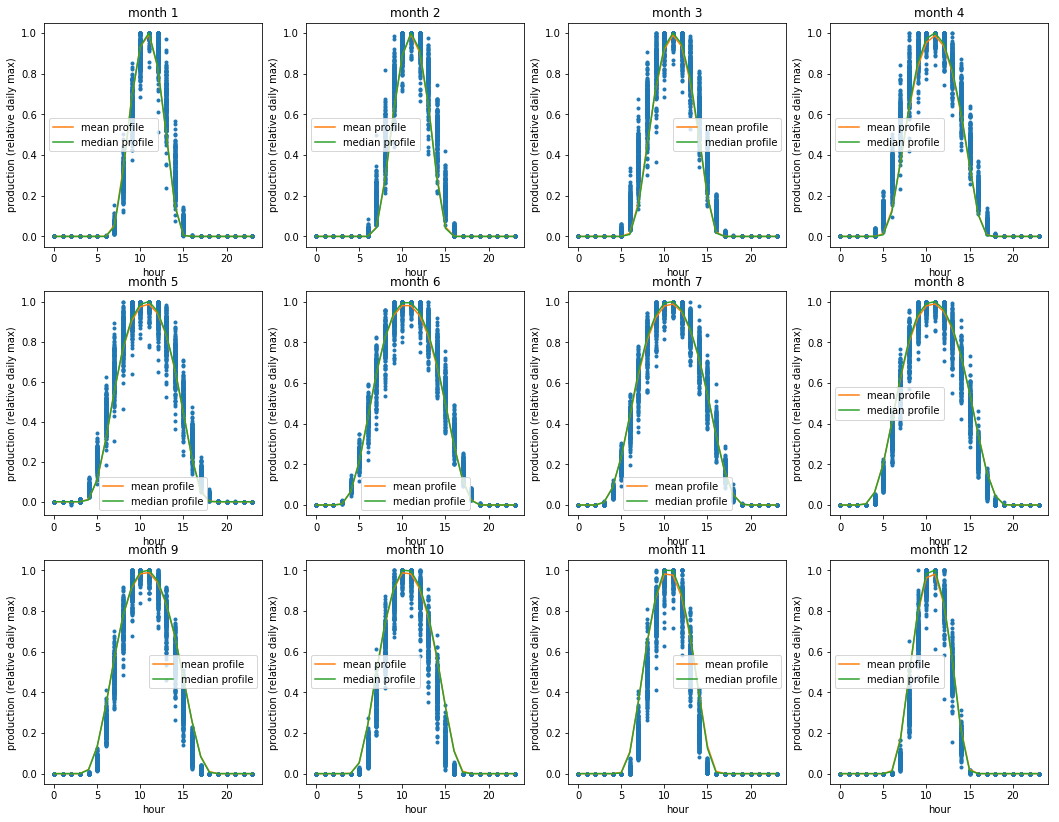

In [46]:
plt.figure(figsize=(18,14))
for i,m in enumerate(solar.month.unique()):
    sel = solar[solar.index.month==m]
    plt.subplot(3,4, i+1)
    plt.plot(sel.index.hour.values, sel['rel_production'].values,'.')
    plt.plot(monthly_solar_profile[i-1,:], label='mean profile')
    plt.plot(monthly_solar_profile_median[i-1,:], label='median profile')
    plt.title('month ' + str(m))
    plt.legend()
    plt.xlabel('hour')
    plt.ylabel('production (relative daily max)')

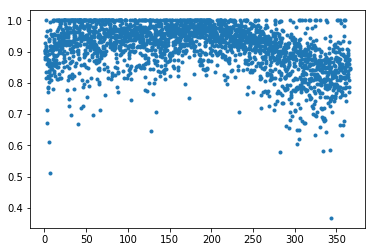

In [29]:
for h in range(12,13):#24):
    sel = solar[solar.index.hour==h]
    plt.plot(sel['day'].values, sel['rel_production'].values,'.')
    #for d in range(366):
    #    plt.plotdepp = solar.groupby(by='day').mean()
#plt.plot()

## Setup Model

In [48]:
solar_model = rdm.SolarPowerModel(ou_model_solar, solar_profile, pf_target_solar)

In [61]:
n_sims = 100
np.random.seed(42)
tg = DateTimeGrid(start=dt.datetime(2022,1,1), end=dt.datetime(2023,1,1), freq='1H')
rnd = np.random.normal(size=(tg.shape[0], n_sims))
solar_simulated = solar_model.simulate(tg, start_value=0.1, rnd=rnd)

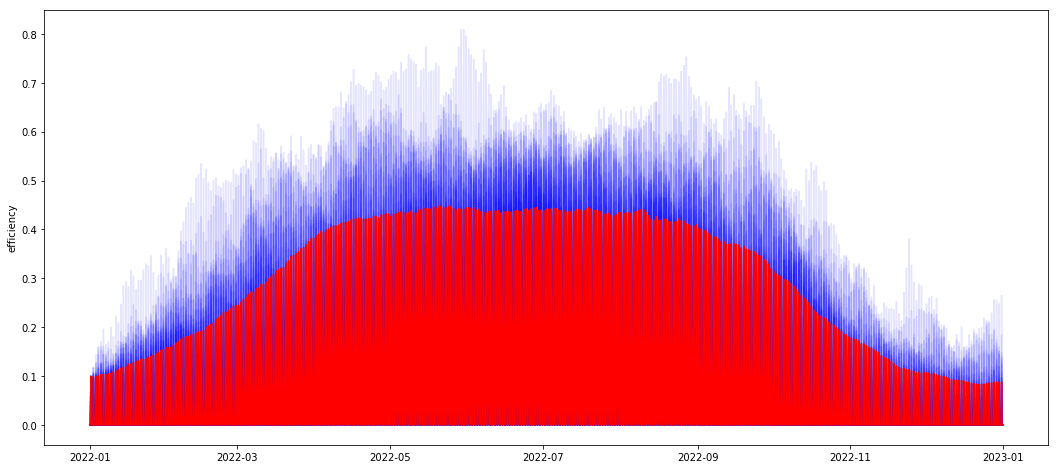

In [62]:
plt.figure(figsize=(18,8))
for i in range(30):
    plt.plot(tg.dates, solar_simulated[:,i],'-b', alpha=0.1)
plt.plot(tg.dates, solar_simulated.mean(axis=1), '-r', label='mean')
plt.ylabel('efficiency');